In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


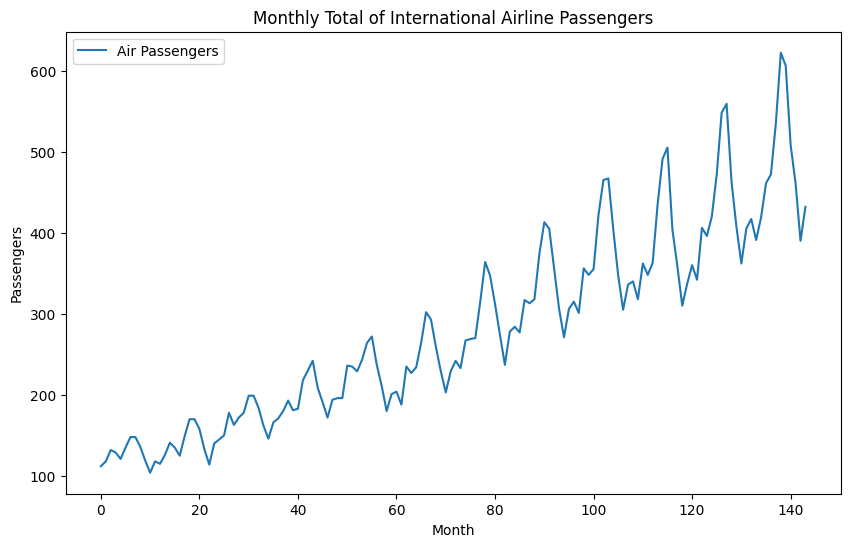

In [ ]:
# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(url, usecols=[1])
data = data.values.astype('float32')

# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Air Passengers')
plt.title('Monthly Total of International Airline Passengers')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(data_normalized, seq_length)

# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

In [ ]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(LSTM, self).__init__()
        # Number of features in the input
        self.hidden_layer_size = hidden_layer_size
        # LSTM layer with input size (features) and hidden layer size (units)
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        # Fully connected linear layer that maps from hidden state to output
        self.linear = nn.Linear(hidden_layer_size, output_size)
        # Initialize hidden state and cell state with zeros
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        # input_seq.view is to reshape the input sequence for the LSTM layer
        # LSTM layer's expected input shape: (sequence_length, batch_size, input_size). Here, `sequence_length` is the length of the input sequence, `batch_size` is set to 1, and `input_size` is the number of features (1 in this example).
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        # lstm_out.view is to reshape the LSTM output for the linear layer
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        # Index -1 is to return the last prediction in the sequence
        return predictions[-1]


In [ ]:
model = LSTM()
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   0 loss: 0.00940026
epoch:  10 loss: 0.01955233
epoch:  20 loss: 0.01080030
epoch:  30 loss: 0.00656138
epoch:  40 loss: 0.00547089
epoch:  50 loss: 0.01221679
epoch:  60 loss: 0.01027341
epoch:  70 loss: 0.00851754
epoch:  80 loss: 0.00994071
epoch:  90 loss: 0.00938606
epoch:  99 loss: 0.0157322474


Root Mean Squared Error: 73.15206019321384


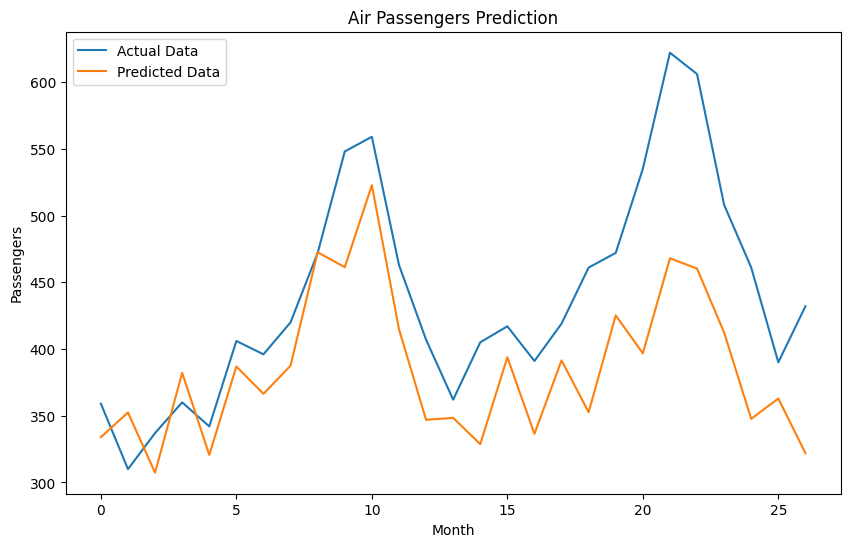

In [ ]:
model.eval()
test_outputs = []

for seq in X_test:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        test_outputs.append(model(seq).item())

test_outputs = scaler.inverse_transform(np.array(test_outputs).reshape(-1, 1))
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, test_outputs))
print(f'Root Mean Squared Error: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Data')
plt.plot(test_outputs, label='Predicted Data')
plt.title('Air Passengers Prediction')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()


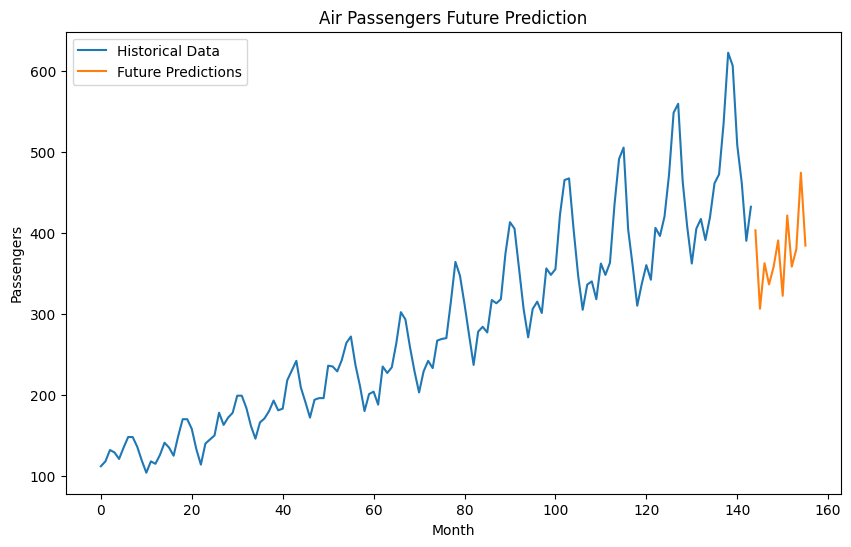

In [ ]:
def predict_future(model, data, future_periods, seq_length):
    predictions = data[-seq_length:].tolist()
    predictions = [item for sublist in predictions for item in sublist]  # Flatten the list
    model.eval()
    for _ in range(future_periods):
        seq = torch.FloatTensor(predictions[-seq_length:])
        with torch.no_grad():
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                torch.zeros(1, 1, model.hidden_layer_size))
            predictions.append(model(seq).item())
    return predictions[seq_length:]

# Predict future values
future_periods = 12
predictions = predict_future(model, data_normalized, future_periods, seq_length)
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(data_normalized), label='Historical Data')
plt.plot(np.arange(len(data_normalized), len(data_normalized) + future_periods), predictions, label='Future Predictions')
plt.title('Air Passengers Future Prediction')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()
